# lightGBM
## 目的
* lightGBMについてざっくり理解する
* lightGBMを触る

[参考にしたkernel](https://www.kaggle.com/caicell/fun-python-eda-step-by-step)

In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# plotlyでアカウントを作成しておく
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='tai_hatake', api_key='dkLnQnKdou9glI2QcZsg')

In [29]:
# import data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [30]:
df_train = train
df_test = test

In [31]:
# ステップ1:欠損値を探す
nullIndex = df_train.isnull().any().index[df_train.isnull().any()]
nullTrain = df_train.loc[:, nullIndex].copy()
for col in nullTrain.columns:
    nullPos = nullTrain[col].isnull()
    nullTrain.loc[~nullPos, col] = 'Exist'
    nullTrain.loc[nullPos, col] = 'Null'

nullTrain = nullTrain.apply(lambda x: pd.Series.value_counts(x)).T
nullTrain = nullTrain.sort_values('Exist')

# 値あり
trace1 = go.Bar(
    x = nullTrain['Exist'],
    y = nullTrain.index,
    name = 'Exist',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
# 値なし
trace2 = go.Bar(
    x = nullTrain['Null'],
    y = nullTrain.index,
    name = 'Null',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)


data = [trace1, trace2]
layout1 = go.Layout(
    width = 800,
    height = 400,
    barmode = 'stack',
    title = 'Null Value BarPlot'
    )
fig = go.Figure(data = data, layout = layout1)

# グラフ化
py.iplot(fig)

In [32]:
# 欠損値を埋めていく。
## 0を埋めていく
indexList = df_train.index
print('Number of Missing Index Sum (MaxVnrType, MasVnrARea, Electrical) : ', sum(indexList[df_train[['MasVnrType', 'MasVnrArea', 'Electrical']].isnull().sum(axis=1)]))
df_train = df_train.loc[df_train[['Electrical', 'MasVnrArea', 'MasVnrType']].isnull().sum(axis=1) == 0, :]

print('Correlation Between GarageYrBlt and YearBlt: ', df_train[['GarageYrBlt', 'YearBuilt']].corr().loc['GarageYrBlt', 'YearBuilt'].round(2))
val = round(max(df_train.corr().loc['LotFrontage', :].drop('LotFrontage')),2)
print('Max Correlation of LotFrontage : ', val)
print('-- Linear Imputation : LotFrontage-- ')
dfImpute = df_train.loc[:, ['1stFlrSF', 'LotArea', 'LotFrontage']].copy()
testIx = dfImpute.loc[:,'LotFrontage'].isnull()

Number of Missing Index Sum (MaxVnrType, MasVnrARea, Electrical) :  17
Correlation Between GarageYrBlt and YearBlt:  0.82
Max Correlation of LotFrontage :  0.46
-- Linear Imputation : LotFrontage-- 


In [33]:
# 線形回帰でモデル作成〜予測
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['1stFlrSF', 'LotArea', 'LotArea']], dfTrain.loc[:, 'LotFrontage'])
lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'LotArea', 'LotArea']])

In [34]:
from collections import Counter, defaultdict
def checkOutlier(df, m = 4):
    uniOutlier = dict().fromkeys(df.columns, None)
    outSample = abs(df - df.mean()) > 4 * df.std()
    outSum = (abs(df - df.mean()) > 4 * df.std()).sum()
    for key in uniOutlier.keys():
        uniOutlier[key] = set(outSample.index[outSample.loc[:, key]])
    outportion = outSum / df.shape[0]
    #print("No outlier Vars: " ,outSum.index[outportion == 0].tolist())
    #print("Outlier Portion")
    #print(outportion[outportion != 0].index.tolist())
    #print(outportion[outportion != 0].values.tolist())
    outportion = outportion[outportion != 0].sort_values()
    outlierLst = outportion.index.tolist()
    return uniOutlier, outlierLst

from collections import Counter
def outlierCounter(outlierDict, exceptionLst = ['SalePrice']):
    inter = Counter()
    name = defaultdict(list)
    coreKey = set(outlierDict.keys()).difference(exceptionLst)
    for key in coreKey:
        value = outlierDict[key]
        for val in value:
            inter[val] += 1
            name[val].append(key)
    res = pd.DataFrame([inter, name], index = ['count', 'variable']).T
    res = res.sort_values('count', ascending = False)
    return res

from scipy.stats import multivariate_normal
def bivarCI(dfNum, y = 'SalePrice', outer = 10, z_score = 0.00006, cols = 2):
    
    colNum = dfNum.shape[1]
    row, col = divmod(colNum-1, cols)
    if row == 1 and col == 0: row += 1
    if col != 0: row += 1
    
    
    z_under = z_score * 0.98
    z_upper = z_score * 1.02
    
    biOutlier = dict().fromkeys(dfNum.columns, None)
    #f, axes = plt.subplots(row, cols, figsize = (4*cols, 4*row))
    #f.suptitle('Bivaraite CI', fontsize = 12)
    for ix, var1 in enumerate(dfNum.columns):
        if var1 == y: break
        r,c = divmod(ix, cols)
        dfPart = dfNum.loc[:, [var1,y]]
        dfPart = dfPart[~dfPart.isnull()].copy()
        dfPart = dfPart.loc[dfPart.loc[:, var1] != 0,:]
        dfPart = (dfPart - dfPart.mean()) / dfPart.std()
        F, X, Y, posProb = bivarConverter(dfPart, outer, z_under, z_upper, N = 700)
        #axes[r,c].contourf(X, Y, posProb)
        #axes[r,c].scatter(dfPart.loc[:, var1], dfPart.loc[:, y], alpha = 1)
        #axes[r,c].set_title('Bivaraite CI ' + var1)
        dfPartProb = F.pdf(dfPart.values)
        outIndex = dfPart.index[dfPartProb < z_score]
        biOutlier[var1] = set(outIndex.tolist())
    #f.tight_layout(rect = [0, 0.03, 1, 0.95])
    #plt.show()
    
    return biOutlier

def bivarConverter(df, outer, z_under, z_upper, N = 500):
    x_init, y_init = df.min() - outer
    x_end, y_end = df.max() + outer
    X = np.linspace(x_init, x_end, N)
    Y = np.linspace(y_init, y_end, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:,:,0] = X
    pos[:,:,1] = Y
    F = multivariate_normal(mean=df.mean().values, cov=df.corr().values)
    posProb = F.pdf(pos)
    posProb[(z_under < posProb) & (posProb < z_upper)] = 1
    posProb[(z_under > posProb) | (posProb < z_upper)] = 0
       
    return F , X, Y, posProb

In [35]:
# 1つの外れ値と外れ値リストのヘルパー関数を実行
cols = ['GrLivArea', 'LotArea', '1stFlrSF', 'TotalBsmtSF', 'SalePrice']
uniOutlier, outlierList = checkOutlier(df_train.loc[:, cols])
uniOut = outlierCounter(uniOutlier, ['SalePrice'])
biOutlier = bivarCI(df_train.loc[:, cols], outer = 2, z_score = 0.00006,  cols = 4)
biOut = outlierCounter(biOutlier, ['SalePrice', ])
totOut = uniOut.join(biOut, lsuffix='_uni', rsuffix='_bi')
print('Top 3 Outlier')
totOut.head(3)

Top 3 Outlier


,count_uni,variable_uni,count_bi,variable_bi
1298,4,"[TotalBsmtSF, GrLivArea, 1stFlrSF, LotArea]",4,"[TotalBsmtSF, GrLivArea, 1stFlrSF, LotArea]"
523,3,"[TotalBsmtSF, GrLivArea, 1stFlrSF]",3,"[TotalBsmtSF, GrLivArea, 1stFlrSF]"
496,2,"[TotalBsmtSF, 1stFlrSF]",2,"[TotalBsmtSF, 1stFlrSF]"


In [36]:
outIndex = [1298, 769, 706, 249, 313, 457, 451, 384, 335, 1396]
outIndex2 = [1298, 523, 496, 440, 332]
outpos =  df_train.index.isin(outIndex)
inpos = ~outpos
outpos2 = df_train.index.isin(outIndex2)
inpos2 = ~outpos2

trace1 = go.Scatter(
    x = df_train.loc[inpos,'LotArea'],
    y = df_train.loc[inpos,'SalePrice'],
    mode = 'markers',
    marker = dict(
        color='rgba(217, 217, 217, 1.0)',
    ),
    text = 'Inner'
)
trace2 =  go.Scatter(
    x = df_train.loc[outIndex,'LotArea'],
    y = df_train.loc[outIndex, 'SalePrice'],
    mode = 'markers',
    marker = dict(
        color= 'rgba(156, 165, 196, 0.95)',
    ),
    text = 'Outlier'
)

trace3 = go.Scatter(
    x = df_train.loc[inpos2, 'LotArea'],
    y = df_train.loc[inpos2,'TotalBsmtSF'],
    mode = 'markers',
    marker = dict(
        color='rgba(217, 217, 217, 1.0)',
    ),
    xaxis = 'x2',
    yaxis = 'y2',
    text = 'Inner'
)
trace4 =  go.Scatter(
    x = df_train.loc[outIndex,'LotArea'],
    y = df_train.loc[outIndex, 'TotalBsmtSF'],
    mode = 'markers',
    marker = dict(
        color= 'rgba(156, 165, 196, 0.95)',
    ),
    xaxis = 'x2',
    yaxis = 'y2',
    text = 'Outlier'
)

xaxisDict =  dict(
            ticklen = 5,
            showgrid = True,
            zeroline = False,
            showline = False)
yaxisDict = dict(
        showgrid = True,
        zeroline = False,
        ticklen =5,
        gridwidth = 0
    )
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    width = 800,
    height = 400,
    title = 'Outlier Detection',
    hovermode = 'closest',
    paper_bgcolor='rgb(254, 247, 234)',
    plot_bgcolor='rgb(254, 247, 234)',
    xaxis1 = xaxisDict,
    yaxis1 = yaxisDict,
    xaxis2 = xaxisDict,
    yaxis2 = yaxisDict,
    showlegend = False
)

fig = go.Figure(data = data, layout = layout)
fig.layout.xaxis1.update({'anchor': 'y1', 'domain' : [0, 0.45], 'title': 'LotArea'})
fig.layout.yaxis1.update({'anchor': 'x1', 'domain': [0, 1], 'title': 'SalePrice'})
fig.layout.xaxis2.update({'anchor': 'y2', 'domain' : [0.65, 1], 'title':'LotArea'})
fig.layout.yaxis2.update({'anchor': 'x2', 'domain': [0, 1], 'title' : 'TotalBsmtSF'})
fig.layout.margin.update({'t':75, 'l':50})

py.iplot(fig)

In [37]:
###
df_train = df_train.loc[~df_train.index.isin(totOut.index),:]
df_raw = df_train.copy()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



<Figure size 432x216 with 0 Axes>

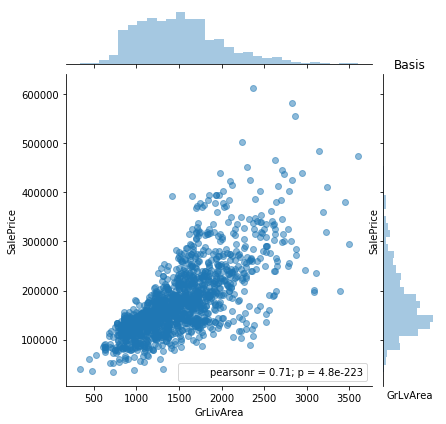

In [40]:
# 販売価格とリビングの広さの変数間の分布を可視化
plt.figure(figsize = (6, 3))
sns.jointplot(df_train.GrLivArea, df_train.SalePrice, alpha = 0.5)
plt.xlabel('GrLvArea')
plt.ylabel('SalePrice')
plt.title('Basis')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.



Mean squared error: 1658201447.99


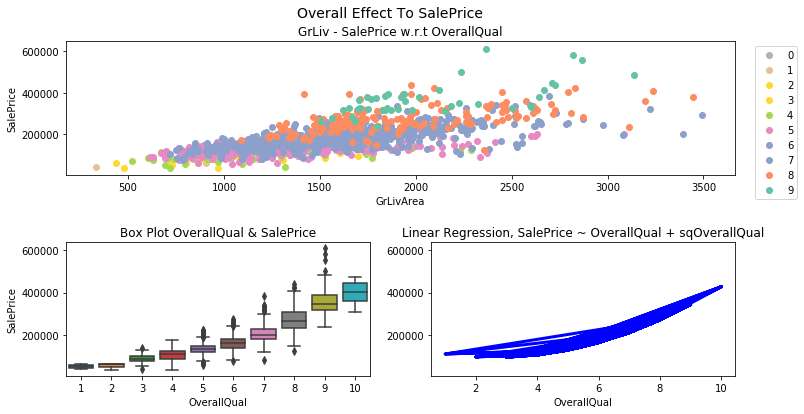

In [41]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

plt.figure(figsize = (12,6))
ax1 = plt.subplot2grid((2,2), (0,0), colspan = 2)
ax1.set_color_cycle(sns.color_palette('Set2_r', 10))
for val in range(10):
    indeX = df_train.OverallQual == val
    ax1.scatter(df_train.GrLivArea.loc[indeX], df_train.SalePrice.loc[indeX], label = val)
ax1.legend(bbox_to_anchor = [1.1, 1])
ax1.set_xlabel('GrLivArea')
ax1.set_ylabel('SalePrice')
ax1.set_title('GrLiv - SalePrice w.r.t OverallQual')

Text(0.5,1,'Box Plot OverallQual & SalePrice')

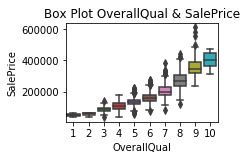

In [45]:
ax2 = plt.subplot2grid((2,2), (1,0))
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = df_train, ax = ax2)
ax2.set_title('Box Plot OverallQual & SalePrice', fontsize = 12)

Mean squared error: 1658201447.99


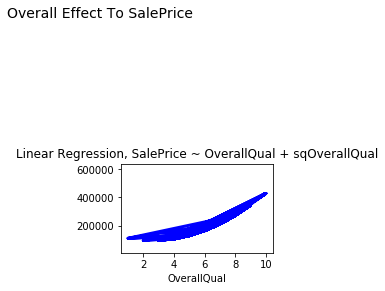

In [44]:
ax3 = plt.subplot2grid((2,2), (1,1))
cubicQual = df_train.groupby(['OverallQual'])['SalePrice'].mean().round(0)
testTrain = df_train.loc[:, ['OverallQual', 'SalePrice']].copy()
testTrain['sqOverallQual'] = np.power(testTrain['OverallQual'],2)
mdl = linear_model.LinearRegression()
mdl.fit(testTrain[['OverallQual', 'sqOverallQual']], testTrain['SalePrice'])
y_pred = mdl.predict(testTrain[['OverallQual', 'sqOverallQual']])
print("Mean squared error: %.2f" % mean_squared_error(y_pred, testTrain.SalePrice))

# Plot outputs
ax3.scatter(testTrain['OverallQual'], testTrain['SalePrice'],  color='w')
ax3.plot(testTrain['OverallQual'], y_pred, color='blue', linewidth=3)
ax3.set_title('Linear Regression, SalePrice ~ OverallQual + sqOverallQual', fontsize = 12)
ax3.set_xlabel('OverallQual')
plt.subplots_adjust(hspace = 0.5, top = 0.9)
plt.suptitle('Overall Effect To SalePrice', fontsize = 14)
plt.show()